# Aprendizaje Supervisado

In [1]:
#Importaciones iniciales
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np

## Lectura de Datos

Como ya se quitó la estacionalidad en tareas anteriores, ya leemos directamente esos datos.

In [2]:
#Lectura de datos
datosGeneracion = pd.read_excel("../Datasets/Información Planta Solar Estacionaria.xlsx")
datosGeneracion_sel = datosGeneracion.copy()
datosGeneracion_sel = datosGeneracion_sel.drop(columns = ['Fecha', 'DesCondCielo', 'DesDirViento'])

In [3]:
#Normalizamos la información
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled = scaler.fit_transform(datosGeneracion_sel)
datosGeneracion_scaled = pd.DataFrame(scaled, columns = datosGeneracion_sel.columns, index=datosGeneracion_sel.index)

In [4]:
#Eliminamos los vacíos
datosGeneracion_dropna = datosGeneracion_scaled.dropna()
datosGeneracion_dropna.head(4)

,Anio,Mes,NumMes,NumSemana,NumDiaAnio,Dia,NumDia,Hora,NumHora,Generacion,...,Generacion_diff,Temperatura_diff,ProbabilidadLluvia_diff,HumedadRelativa_diff,VelocidadViento_diff,DireccionViento_diff,IndiceUV_diff,VelocidadRafaga_diff,Precipitacion_diff,DPT_diff
24,0.0,0.0,0.545455,0.5,0.502778,0.001264,0.033333,0.001263,0.000000,0.0,...,0.500199,0.447368,0.527950,0.500000,0.559045,0.494949,0.444444,0.494208,0.563265,0.507246
25,0.0,0.0,0.545455,0.5,0.502778,0.001264,0.033333,0.001315,0.043478,0.0,...,0.500199,0.473684,0.552795,0.494048,0.584171,0.494949,0.444444,0.494208,0.563265,0.507246
26,0.0,0.0,0.545455,0.5,0.502778,0.001264,0.033333,0.001368,0.086957,0.0,...,0.500199,0.473684,0.534161,0.505952,0.559045,0.494949,0.444444,0.494208,0.563265,0.507246
27,0.0,0.0,0.545455,0.5,0.502778,0.001264,0.033333,0.001420,0.130435,0.0,...,0.500199,0.447368,0.503106,0.500000,0.584171,0.494949,0.444444,0.494208,0.563265,0.492754


## Entrenamiento para elegir mejor modelo

In [5]:
#Importaciones de todos los modelos
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, BayesianRidge, LogisticRegression
import xgboost
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from sklearn.pipeline import make_pipeline

In [6]:
def fit(x, y, reg_model = 'RF', n_components = 3, n_jobs = None):
    match reg_model:
        case 'AdaBoost':
            model = AdaBoostRegressor()
        case 'Bagging':
            model = BaggingRegressor(n_jobs = n_jobs)
        case 'BayesRidge':
            model = BayesianRidge()
        case 'Boosting':
            model = GradientBoostingRegressor()
        case 'DecisionTree':
            model = DecisionTreeRegressor(max_depth = 2)
        case 'LassoReg':
            model = Lasso(alpha = 0.1)
        case 'LinearReg':
            model = LinearRegression(n_jobs = n_jobs)
        case 'PLS':
            model = PLSRegression(n_components = n_components)
        case 'PCR':
            model = make_pipeline(PCA(n_components = n_components), LinearRegression(n_jobs = n_jobs))
        case 'RidgeReg':
            model = Ridge(alpha = 0.1)
        case 'RF':
            model = RandomForestRegressor(n_jobs = n_jobs)
        case 'XGBoost':
            model = xgboost.XGBRegressor(n_jobs = n_jobs)
    model.fit(x, y)
    return model

In [7]:
#Librerías de las métricas
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2

In [8]:
#Selección de información
y = datosGeneracion_dropna[['Generacion_diff']]
x = datosGeneracion_dropna[['NumSemana', 'NumDiaAnio', 'Hora','Temperatura_diff', 'ProbabilidadLluvia_diff',
                                 'HumedadRelativa_diff', 'VelocidadViento_diff', 'CoberturaNubes',
                                 'IndiceUV_diff', 'CodDirViento', 'DPT_diff']]

In [9]:
#Datos de Entrenamiento
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit()
TimeSeriesSplit(gap=0,max_train_size=None, n_splits=5, test_size=None)
for i, (train_index, test_index) in enumerate(tscv.split(x)):
    print(f"Fold {i}:")
    print(f" Train: index={train_index}")
    print(f" Test: index={test_index}")

Fold 0:
 Train: index=[   0    1    2 ... 3154 3155 3156]
 Test: index=[3157 3158 3159 ... 6307 6308 6309]
Fold 1:
 Train: index=[   0    1    2 ... 6307 6308 6309]
 Test: index=[6310 6311 6312 ... 9460 9461 9462]
Fold 2:
 Train: index=[   0    1    2 ... 9460 9461 9462]
 Test: index=[ 9463  9464  9465 ... 12613 12614 12615]
Fold 3:
 Train: index=[    0     1     2 ... 12613 12614 12615]
 Test: index=[12616 12617 12618 ... 15766 15767 15768]
Fold 4:
 Train: index=[    0     1     2 ... 15766 15767 15768]
 Test: index=[15769 15770 15771 ... 18919 18920 18921]


In [10]:
#Datos de Entrenamiento
#Procesamos los modelos
from tqdm import tqdm
import multiprocessing
from timeit import default_timer as timer

models_ed = ['AdaBoost', 'Boosting', 'DecisionTree', 'LassoReg', 'PCR',
                      'Bagging', 'RF', 'LinearReg', 'BayesRidge', 'RidgeReg', 'PLS', 'XGBoost']
n_jobs = multiprocessing.cpu_count()
results_ed = {
        'model' : [],
        'mse' : [],
        'rmse' : [],
        'mae' : [],
        'r2' : [],
        'mape' : [],
        'time' : [],
        'i': [],
        'train': [],
        'test': []
}

for k in tqdm(range(30)):
    for i, (train_index, test_index) in enumerate(tscv.split(x)):
        y_train = y.loc[24:len(train_index),]
        x_train = x.loc[24:len(train_index),]

        y_test = y.loc[test_index]
        x_test = x.loc[test_index]    
    
        for m in models_ed:
                start = timer()
                model = fit(x_train, y_train.Generacion_diff.ravel(), m, n_jobs = n_jobs)
                end = timer()
                y_pred = model.predict(x_test)
                results_ed['model'].append(m)
                results_ed['mse'].append(mse(y_test, y_pred))
                results_ed['rmse'].append(np.sqrt(mse(y_test, y_pred)))
                results_ed['mae'].append(mae(y_test, y_pred))
                results_ed['r2'].append(r2(y_test, y_pred))
                results_ed['mape'].append(mape(y_test, y_pred))
                results_ed['i'].append(i)
                results_ed['train'].append(len(train_index))
                results_ed['test'].append(len(test_index))
                results_ed['time'].append(end - start)

df_results_ed = pd.DataFrame(results_ed)
df_results_ed.to_csv('./Resultados_modelos_PCA4.csv')

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [51:33<00:00, 103.13s/it] 


## RMSE

In [11]:
df_results_ed = pd.read_csv('./Resultados_modelos_PCA.csv', index_col = 0)

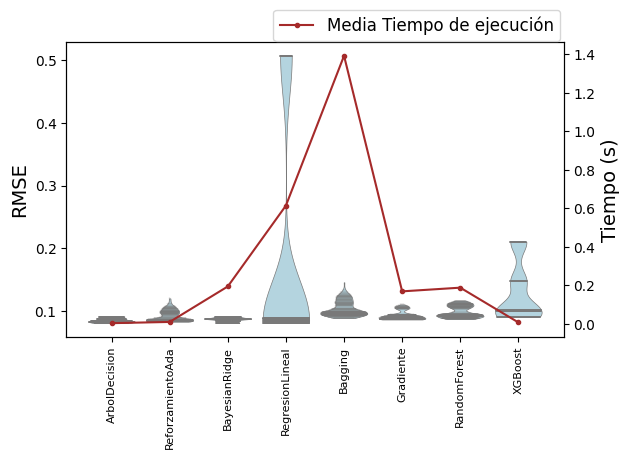

In [33]:
filter = df_results_ed["i"]==0
ff_results_ed = df_results_ed.where(filter).sort_values('rmse')
gp_results_ed = ff_results_ed.groupby('model').mean()
gp_results_ed = gp_results_ed.sort_values('rmse')
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
plt.figure()
ax = plt.gca()
sns.violinplot(x="model", y="rmse", data=df_results_ed, cut=0, inner = 'stick', scale = 'width', linewidth = 0.5, color = 'lightblue')
plt.xticks(rotation = 90, fontsize = 8)
plt.ylabel('RMSE', fontsize = 14)
plt.xlabel('')

ax2 = ax.twinx()
ax2.plot(gp_results_ed.time, '.-', c = 'brown', label = 'Media Tiempo de ejecución')
plt.ylabel('Tiempo (s)', fontsize = 14)
plt.legend(bbox_to_anchor = (1.01, 1.14), fontsize = 12)
plt.tight_layout()
plt.show()

## MAE

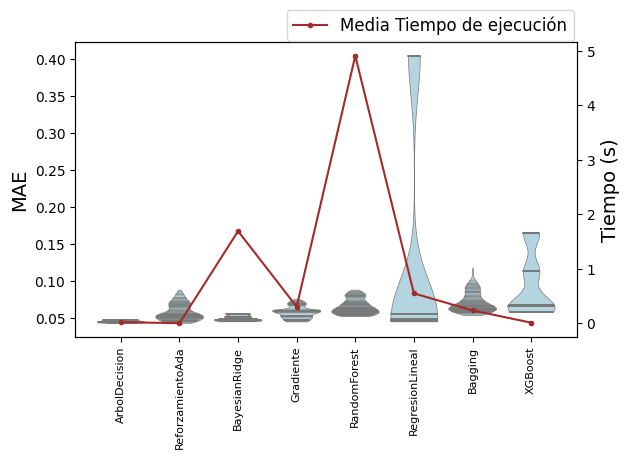

In [13]:
filter = df_results_ed["i"]==2
ff_results_ed = df_results_ed.sort_values('mae')
gp_results_ed = ff_results_ed.groupby('model').mean()
gp_results_ed = gp_results_ed.sort_values('mae')
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
plt.figure()
ax = plt.gca()
sns.violinplot(x="model", y="mae", data=df_results_ed, cut=0, inner = 'stick', scale = 'width', linewidth = 0.5, color = 'lightblue')
plt.xticks(rotation = 90, fontsize = 8)
plt.ylabel('MAE', fontsize = 14)
plt.xlabel('')

ax2 = ax.twinx()
ax2.plot(gp_results_ed.time, '.-', c = 'brown', label = 'Media Tiempo de ejecución')
plt.ylabel('Tiempo (s)', fontsize = 14)
plt.legend(bbox_to_anchor = (1.01, 1.14), fontsize = 12)
plt.tight_layout()
plt.show()

## R2

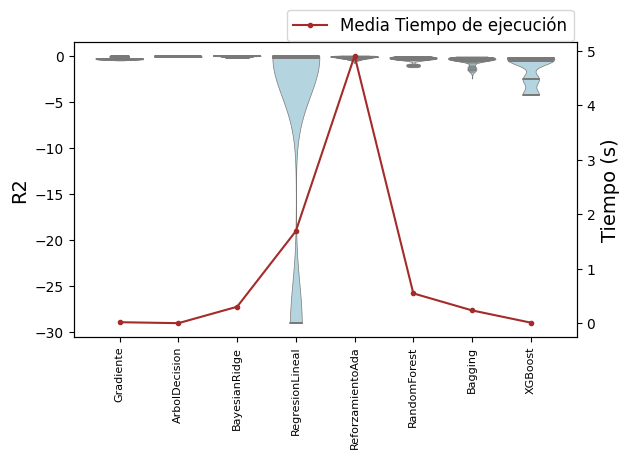

In [14]:
df_results_ed = df_results_ed.sort_values('r2', ascending=False)
gp_results_ed = df_results_ed.groupby('model').mean()
gp_results_ed = gp_results_ed.sort_values('r2', ascending=False)
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
plt.figure()
ax = plt.gca()
sns.violinplot(x="model", y="r2", data=df_results_ed, cut=0, inner = 'stick', scale = 'width', linewidth = 0.5, color = 'lightblue')
plt.xticks(rotation = 90, fontsize = 8)
plt.ylabel('R2', fontsize = 14)
plt.xlabel('')

ax2 = ax.twinx()
ax2.plot(gp_results_ed.time, '.-', c = 'brown', label = 'Media Tiempo de ejecución')
plt.ylabel('Tiempo (s)', fontsize = 14)
plt.legend(bbox_to_anchor = (1.01, 1.14), fontsize = 12)
plt.tight_layout()
plt.show()

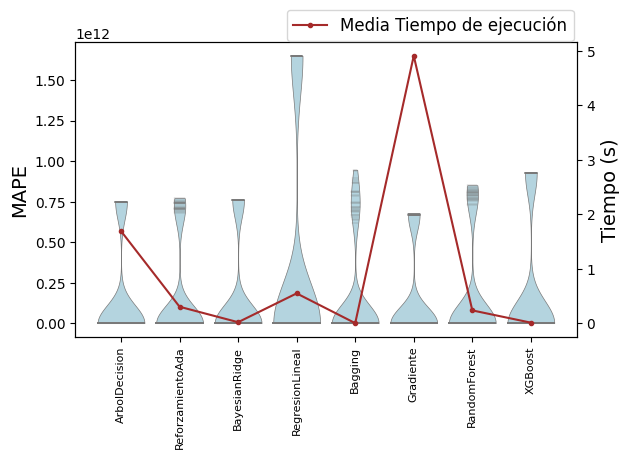

In [15]:
df_results_ed = df_results_ed.sort_values('mape')
gp_results_ed = df_results_ed.groupby('model').mean()
gp_results_ed = gp_results_ed.sort_values('mape')
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
plt.figure()
ax = plt.gca()
sns.violinplot(x="model", y="mape", data=df_results_ed, cut=0, inner = 'stick', scale = 'width', linewidth = 0.5, color = 'lightblue')
plt.xticks(rotation = 90, fontsize = 8)
plt.ylabel('MAPE', fontsize = 14)
plt.xlabel('')

ax2 = ax.twinx()
ax2.plot(gp_results_ed.time, '.-', c = 'brown', label = 'Media Tiempo de ejecución')
plt.ylabel('Tiempo (s)', fontsize = 14)
plt.legend(bbox_to_anchor = (1.01, 1.14), fontsize = 12)
plt.tight_layout()
plt.show()

## Método Random Forest

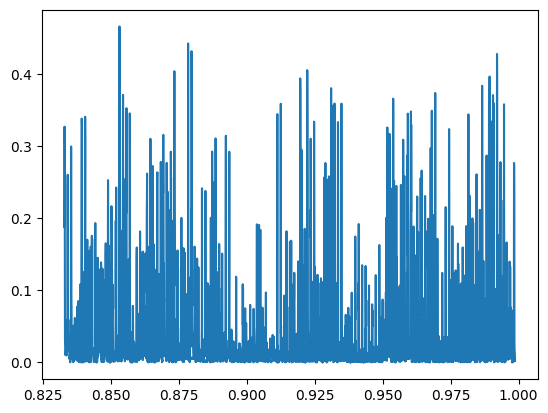

In [56]:
modelRF = BayesianRidge()
modelRF.fit(x_train, y_train)
y_pred_RF = modelRF.predict(x_test)
plt.plot(x_test["Hora"], abs(y_test["Generacion_diff"]- y_pred_RF))


In [57]:
df_y_pred = pd.DataFrame(y_pred_RF, index = y_test.index, columns = ['Generacion_diff'])
df_y_pred

,Generacion_diff
15769,0.495403
15770,0.497956
15771,0.499886
15772,0.496267
15773,0.489780
...,...
18917,0.489804
18918,0.486318
18919,0.486353
18920,0.495076


In [58]:
#Indicamos las filas que han sido predecidas por el método Bagging
datosGeneracion['predecida'] = 0
datosGeneracion.loc[df_y_pred.index, 'predecida'] = 1

In [59]:
#Igualamos la predición con la generación
datosGeneracion['prediccion_diff'] = datosGeneracion_scaled['Generacion_diff']

In [60]:
#Asignamos los datos de predicción a la columna
datosGeneracion.loc[df_y_pred.index, 'prediccion_diff'] = df_y_pred['Generacion_diff']

In [61]:
#Obtenemos el máximo y el mínimo para desecalar
max_value = datosGeneracion_dropna["Generacion_diff"].max()
min_value = datosGeneracion_dropna["Generacion_diff"].min()

In [62]:
#Desescalamos
datosGeneracion["Prediction"] = round((datosGeneracion["prediccion_diff"] * (max_value - min_value)) + min_value, 2)

In [63]:
#Inicializamos la columna de predicción final con 0
datosGeneracion['Prediction_final'] = 0

In [64]:
#Pasamos los primeros 24 registros de la generación original a las columnas predictivas
datosGeneracion.loc[0:24, 'Prediction'] = datosGeneracion.loc[0:24, 'Generacion']
datosGeneracion.loc[0:24, 'Prediction_final'] = datosGeneracion.loc[0:24, 'Generacion']

In [65]:
#Desdiferenciamos topando mínimo con 0 y máximo con 30000
for i in range(24, len(datosGeneracion)):
    datosGeneracion['Prediction_final'][i] = min(max(datosGeneracion['Prediction'][i] + datosGeneracion["Prediction_final"][i-24], 0), 30000)

In [66]:
#Condicionamos a que haya valores si el Índice UV tiene valor
datosGeneracion['Prediction_UV'] = datosGeneracion['Prediction_final']
datosGeneracion.loc[(datosGeneracion['IndiceUV'] == 0), 'Prediction_UV'] = 0

In [67]:
mae(datosGeneracion[['Generacion']], datosGeneracion[['Prediction_final']])

12448.777267534044

In [68]:
mae(datosGeneracion[['Generacion']], datosGeneracion[['Prediction_UV']])

7687.989234445265

In [69]:
datosGeneracion.loc[-50:,['Generacion', 'Prediction', 'Prediction_final', 'Prediction_final', 'predecida']]

,Generacion,Prediction,Prediction_final,Prediction_final,predecida
0,0.0000,0.00,0.0000,0.0000,0
1,0.0000,0.00,0.0000,0.0000,0
2,0.0000,0.00,0.0000,0.0000,0
3,0.0000,0.00,0.0000,0.0000,0
4,0.0000,0.00,0.0000,0.0000,0
...,...,...,...,...,...
18941,1732.7788,0.52,394.4900,394.4900,0
18942,0.0000,0.50,394.4600,394.4600,0
18943,0.0000,0.50,646.9551,646.9551,0
18944,0.0000,0.50,1184.1089,1184.1089,0


In [70]:
def line_plotting(title, data, x, y, y2, x_label, y_label, width, height):
    """General function to plot"""
    plt.figure(figsize=(width,height))
    plt.plot(data[x], data[y], color='lightblue')   
    plt.plot(data[x], data[y2], color='black')  
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.tight_layout()
    plt.show()

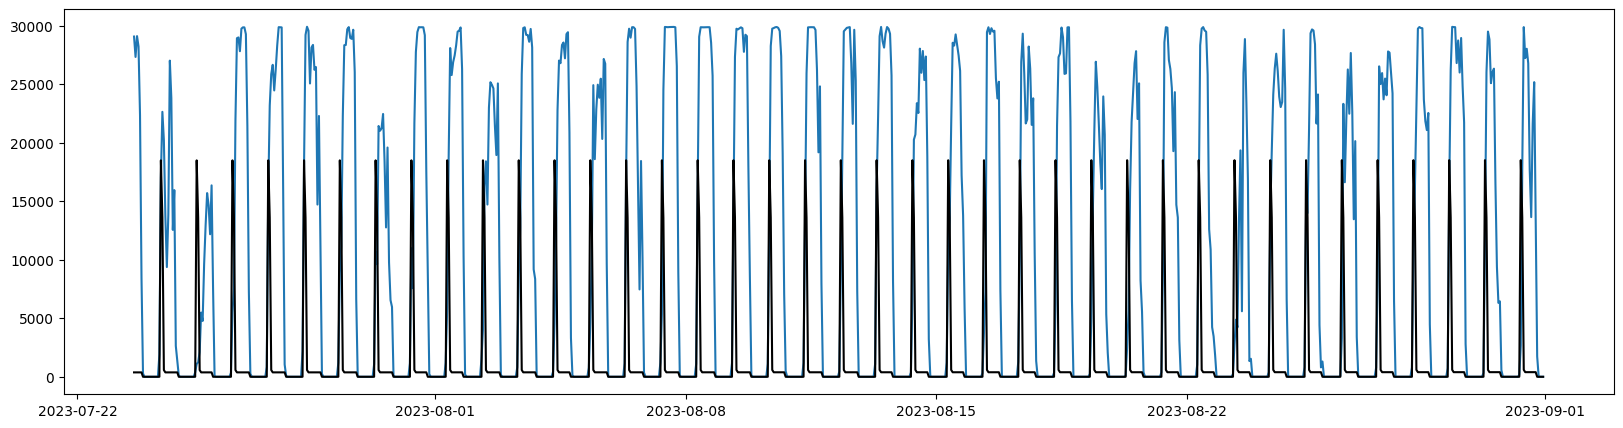

In [71]:
plt.figure(figsize=(20,5))
plt.plot(datosGeneracion.loc[18000:, "Fecha"], datosGeneracion.loc[18000:, "Generacion"])
plt.plot(datosGeneracion.loc[18000:, "Fecha"], datosGeneracion.loc[18000:, "Prediction_UV"], c = 'black')

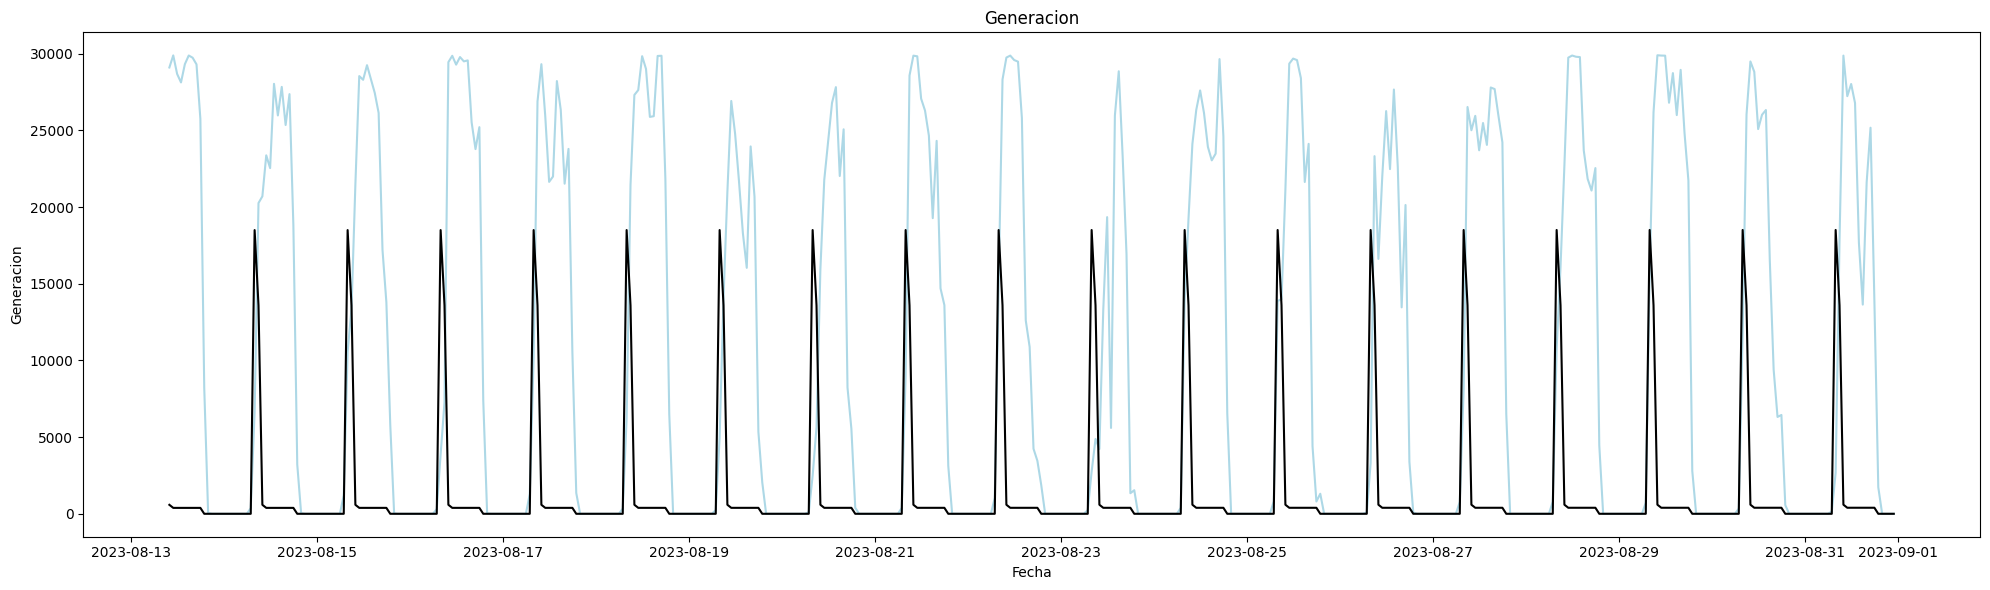

In [72]:
line_plotting('Generacion', datosGeneracion[18500:], 'Fecha', 'Generacion', 'Prediction_UV', 'Fecha', 'Generacion', 20, 6)